<a href="https://colab.research.google.com/github/youngihn/Deeplearning_-/blob/master/deeplearning_%EA%B5%90%EC%9C%A1%EC%9A%A9_%EC%9E%90%EB%A3%8C%20%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras?
* 수 많은 딥러닝 프레임워크들 중 하나입니다. 
* 다른 유명한 딥러닝 프레임워크 : tensorflow, pytorch

## keras의 장점 
* 사용자 친화적 
  * 간결한 API 제공
  * 에러에 대한 명확하고 실용적인 피드백 제공 
  * tensorflow와 호환이 잘 됨

## keras 업계와 학계 양쪽에서 모두 폭넓게 사용 
* 개발된 기능: Netflix, Uber, Yelp 등 
* arXiv.org 업로드 된 과학 논문들 중에서 두 번째로 많이 언급 

* keras 현재 Google의 지원을 중심으로 개발 
* keras 백엔드의 유지보수는 Microsoft 
등등 ...

###Github Cloning 

In [1]:
!git clone https://github.com/youngihn/Deeplearning_-.git

Cloning into 'Deeplearning_-'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25002 (delta 0), reused 0 (delta 0), pack-reused 24999
Receiving objects: 100% (25002/25002), 541.61 MiB | 26.77 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (25003/25003), done.


### Import libraries 

In [22]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, ImageDataGenerator
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

### load img file (jpg)

In [3]:
filenames = os.listdir('Deeplearning_-/train/')

In [4]:
!ls Deeplearning_-/train/*

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Deeplearning_-/train/cat.5501.jpg   Deeplearning_-/train/dog.5501.jpg
Deeplearning_-/train/cat.5502.jpg   Deeplearning_-/train/dog.5502.jpg
Deeplearning_-/train/cat.5503.jpg   Deeplearning_-/train/dog.5503.jpg
Deeplearning_-/train/cat.5504.jpg   Deeplearning_-/train/dog.5504.jpg
Deeplearning_-/train/cat.5505.jpg   Deeplearning_-/train/dog.5505.jpg
Deeplearning_-/train/cat.5506.jpg   Deeplearning_-/train/dog.5506.jpg
Deeplearning_-/train/cat.5507.jpg   Deeplearning_-/train/dog.5507.jpg
Deeplearning_-/train/cat.5508.jpg   Deeplearning_-/train/dog.5508.jpg
Deeplearning_-/train/cat.5509.jpg   Deeplearning_-/train/dog.5509.jpg
Deeplearning_-/train/cat.550.jpg    Deeplearning_-/train/dog.550.jpg
Deeplearning_-/train/cat.5510.jpg   Deeplearning_-/train/dog.5510.jpg
Deeplearning_-/train/cat.5511.jpg   Deeplearning_-/train/dog.5511.jpg
Deeplearning_-/train/cat.5512.jpg   Deeplearning_-/train/dog.5512.jpg
Deeplearning_-/train/cat.5513.jpg   Deeplearning_-/trai

In [5]:
import glob
img_path = 'Deeplearning_-/train/*.jpg'
imgs = glob.glob(img_path)
#len(imgs)

### Define image properties

In [6]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

### Prepare dataset for training 

In [7]:
categories=[]
for filename in filenames:
    category=filename.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [8]:
df

,filename,category
0,dog.6530.jpg,1
1,dog.3373.jpg,1
2,cat.1422.jpg,0
3,dog.7644.jpg,1
4,cat.6379.jpg,0
...,...,...
24995,cat.3486.jpg,0
24996,cat.4936.jpg,0
24997,dog.4557.jpg,1
24998,cat.1966.jpg,0


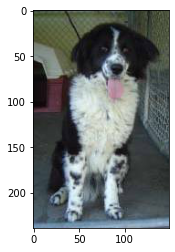

In [9]:
sample = random.choice(filenames)
image = load_img('Deeplearning_-/train/'+sample)
plt.imshow(image)

### Build Model

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation #BatchNormalization, Dropout

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

### Manage data

In [19]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True) 
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=10

20000 5000


In [20]:
print(total_train, total_validate)

20000 5000


### Training data generator

* shear_range : Float type, shear intensity(shear angle in counter-clockwise direction as radians)
* shear means that the image will be distorted along an axis
* zooom_range : Float type, Range for random zoom
* horizontal_flip : Boolean type, Randomly flip inputs horizontally
* rescale : rescaling factor, Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided. 

* flow_from_dataframe : dataframe과 디렉토리의 위치를 전달받아 증강/정규화된 데이터의 배치를 생성합니다. 

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 'Deeplearning_-/train/',x_col='filename',y_col='category',
                                                 target_size=IMAGE_SIZE,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


### Validation data generator 

In [24]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    'Deeplearning_-/train/', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


### Model Training 

In [25]:
epochs=30
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
2000/2000 [==============================] - 91s 46ms/step - loss: 0.6605 - accuracy: 0.6006 - val_loss: 0.6131 - val_accuracy: 0.6784
Epoch 2/30
2000/2000 [==============================] - 91s 45ms/step - loss: 0.5190 - accuracy: 0.7404 - val_loss: 0.5233 - val_accuracy: 0.7438
Epoch 3/30
2000/2000 [==============================] - 91s 46ms/step - loss: 0.4249 - accuracy: 0.8029 - val_loss: 0.4477 - val_accuracy: 0.8112
Epoch 4/30
2000/2000 [==============================] - 91s 46ms/step - loss: 0.3477 - accuracy: 0.8442 - val_loss: 0.4361 - val_accuracy: 0.8002
Epoch 5/30
2000/2000 [==============================] - 91s 46ms/step - loss: 0.2586 - accuracy: 0.8921 - val_loss: 0.4071 - val_accuracy: 0.8278
Epoch 6/30
2000/2000 [==============================] - 90s 45ms/step - loss: 0.1653 - accuracy: 0.9340 - val_loss: 0.6046 - val_accuracy: 0.8144
Epoch 7/30
2000/2000 [==========================

### Virtualize Training

In [26]:
history.history

{'accuracy': [0.600600004196167,
  0.7403500080108643,
  0.8029000163078308,
  0.8441500067710876,
  0.89205002784729,
  0.9339500069618225,
  0.9657999873161316,
  0.9757500290870667,
  0.9841499924659729,
  0.9858499765396118,
  0.9887499809265137,
  0.9878000020980835,
  0.9923499822616577,
  0.9904500246047974,
  0.9911500215530396,
  0.991100013256073,
  0.9937499761581421,
  0.9908999800682068,
  0.993399977684021,
  0.9915500283241272,
  0.9912499785423279,
  0.9958999752998352,
  0.9927999973297119,
  0.9941999912261963,
  0.9937000274658203,
  0.9944000244140625,
  0.9944499731063843,
  0.996999979019165,
  0.9950500130653381,
  0.9932000041007996],
 'loss': [0.6604945659637451,
  0.5190277099609375,
  0.4249119162559509,
  0.3476812243461609,
  0.2585899531841278,
  0.16533906757831573,
  0.09188137948513031,
  0.06726221740245819,
  0.04633169248700142,
  0.041450370103120804,
  0.03442982956767082,
  0.03882383555173874,
  0.02512921206653118,
  0.03211846575140953,
  0.031

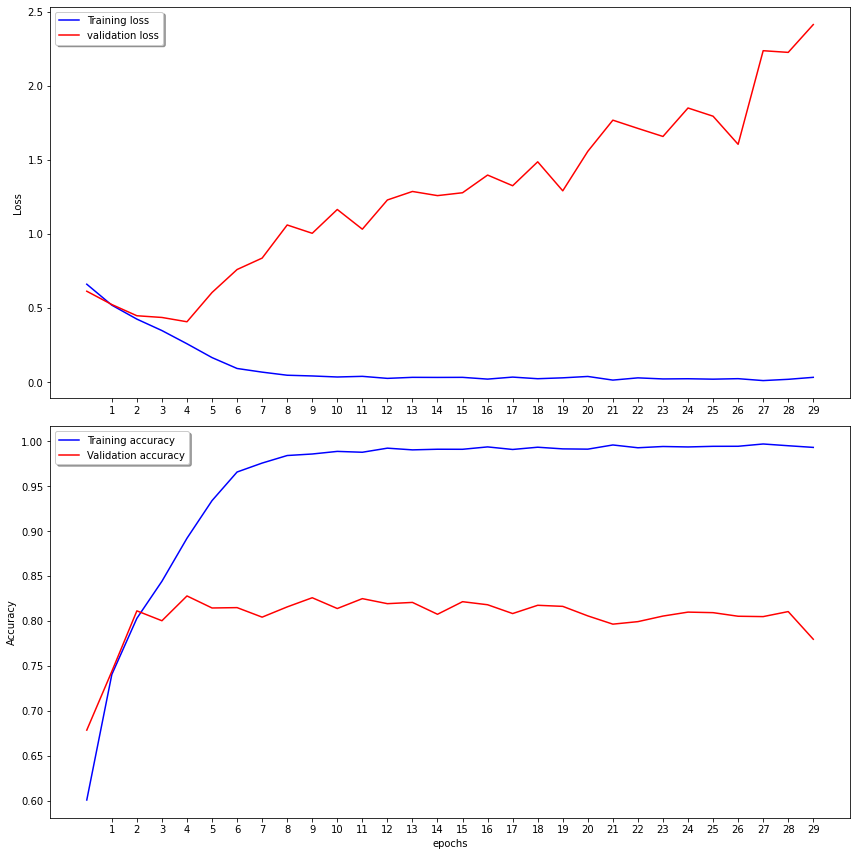

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('Loss')

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best', shadow=True)

plt.xlabel('epochs')
plt.tight_layout()
plt.show()

### 현재 Validation Accuracy: 0.80 ~ 0.85 사이
* 문제점 
  * overfitting 되었다는 걸 확인할 수 있음  
* 정확성을 올리는 방법 
  * Dropout, Batch Normalization 등의 정규화에 도움이 되는 레이어 쌓기 
  * hyper-parameter 변경 (Resolution(해상도), Epoch, Batch Size 등)
  * layer층을 더 쌓기 
  * augmentation 적용 
